In [1]:
# Install required libraries
!pip install yfinance timesfm

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d5d6c66f9cf333beafb76666e02352a89a45cc3ad7de32b7845542e99091737b
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [54]:
import yfinance as yf
import ta
import pandas as pd

# تنظیمات
ticker = 'AAPL'  # Example: Apple Inc.
start_date = "2022-10-12"
end_date = "2024-01-01"
analysis_start_date = "2023-01-03"  # تاریخ شروع مورد نظر

# دانلود داده‌های سهام از Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# محاسبه میانگین‌های متحرک و اندیکاتورهای تکنیکال
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['Close'], window=10).ema_indicator()

# حذف سطرهایی که دارای مقادیر NaN هستند (به دلیل محاسبات میانگین‌های متحرک)
data = data.dropna()

# فیلتر کردن داده‌ها از تاریخ شروع مورد نظر
data = data[data.index >= analysis_start_date]

# تنظیم DataFrame نهایی
df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# نمایش داده‌ها
df


[*********************100%%**********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50,rsi,ema
date,,,,,,
2023-01-03,125.070000,112117500,130.488998,142.709599,32.304320,130.829227
2023-01-04,126.360001,89113600,129.887999,142.291399,34.891363,130.016640
2023-01-05,125.019997,80962700,129.159998,141.802799,33.460886,129.108160
2023-01-06,129.619995,87754700,128.576998,141.348399,42.218538,129.201221
2023-01-09,130.149994,70790800,128.368998,140.964399,43.147003,129.373725
...,...,...,...,...,...,...
2023-12-22,193.600006,37122800,195.747002,185.398801,54.609714,194.957922
2023-12-26,193.050003,28919300,195.734003,185.682801,53.026883,194.611027
2023-12-27,193.149994,48087700,195.578001,185.971400,53.291938,194.345385


In [55]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [37]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [45]:
import timesfm

context_len = 64
batch_size = 1  # ثابت نگه‌داشتن batch size
horizon_len = 1  # ثابت نگه‌داشتن horizon length



In [46]:

    model = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=20,
        model_dims=1280,
        backend="gpu",
    )
    model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.91 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 3.73 seconds.
Jitting decoding.
Jitted decoding in 20.99 seconds.


In [56]:
batch_sizes = range(1, 33, 3)  # لیستی از اندازه‌های مختلف batch size برای آزمایش
results_by_batch_size = []

for batch_size in batch_sizes:


    input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)

    # پردازش و محاسبه سود
    for i, example in enumerate(input_data()):
        raw_forecast, _ = model.forecast(
            inputs=example["inputs"], freq=[0] * len(example["inputs"])
        )
        dynamic_numerical_covariates = {"volume": example["volume"]}
        cov_forecast, ols_forecast = model.forecast_with_covariates(
                   inputs=example["inputs"],
                   dynamic_numerical_covariates=dynamic_numerical_covariates,
                   dynamic_categorical_covariates={},
                   static_numerical_covariates={},
                   static_categorical_covariates={},
                   freq=[0] * len(example["inputs"]),
                   normalize_xreg_target_per_input=True,
                   xreg_mode="timesfm + xreg",)

        for j in range(len(example["inputs"])):
            result = {
                'input_index': j,
                'train_start_date': str(example["dates"][j][0]),
                'train_end_date': str(example["dates"][j][-2]),
                'predict_date': str(example["dates"][j][-1]),
                'raw_forecast': raw_forecast[j][0],
                'y_actual': example["outputs"][j][0],
                'y_predict' : cov_forecast[j][0],
                'batch_size': batch_size,
                'context_len': context_len,

            }
            results_by_batch_size.append(result)



In [57]:
 results_df = pd.DataFrame(results_by_batch_size)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,y_predict,batch_size,context_len
0,0,2023-01-03 00:00:00,2023-04-04 00:00:00,2023-04-05 00:00:00,166.959595,163.759995,174.092331,1,64
1,0,2023-01-04 00:00:00,2023-04-05 00:00:00,2023-04-06 00:00:00,165.057480,164.660004,175.042068,1,64
2,0,2023-01-05 00:00:00,2023-04-06 00:00:00,2023-04-10 00:00:00,165.524902,162.029999,181.442627,1,64
3,0,2023-01-06 00:00:00,2023-04-10 00:00:00,2023-04-11 00:00:00,162.622696,160.800003,177.749954,1,64
4,0,2023-01-09 00:00:00,2023-04-11 00:00:00,2023-04-12 00:00:00,161.525681,160.100006,175.524078,1,64
...,...,...,...,...,...,...,...,...,...
2030,25,2023-09-21 00:00:00,2023-12-20 00:00:00,2023-12-21 00:00:00,195.240768,194.679993,210.875793,31,64
2031,26,2023-09-22 00:00:00,2023-12-21 00:00:00,2023-12-22 00:00:00,194.696457,193.600006,210.615372,31,64
2032,27,2023-09-25 00:00:00,2023-12-22 00:00:00,2023-12-26 00:00:00,194.012909,193.050003,209.948105,31,64
2033,28,2023-09-26 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,193.501053,193.149994,209.570343,31,64


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_by_batch_size)

# Define functions for calculating accuracy and profit
def calculate_accuracy(y_actual, y_pred):
    correct_predictions = 0
    total_predictions = 0

    for i in range(1, len(y_actual)):
        actual_today = y_actual[i]
        predicted_today = y_pred[i]
        actual_yesterday = y_actual[i - 1]

        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday

        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    accuracy_value = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy_value

def calculate_profit(y_actual, y_pred, initial_investment=100):
    capital = initial_investment
    shares = 0

    for i in range(1, len(y_actual)):
        if y_pred[i] > y_pred[i - 1] and capital > 0:
            shares = capital / y_actual[i]
            capital = 0
        elif y_pred[i] < y_pred[i - 1] and shares > 0:
            capital = shares * y_actual[i]
            shares = 0

    final_capital = capital + shares * y_actual[-1]
    profit = final_capital - initial_investment
    return profit

# Calculate metrics for each batch size
final_results = []

for batch_size in batch_sizes:
    batch_results = results_df[results_df['batch_size'] == batch_size]

    y_actual = batch_results['y_actual'].values
    raw_forecast = batch_results['raw_forecast'].values
    cov_forecast = batch_results['y_predict'].values

    # Calculate metrics for raw forecast
    mse_value_raw = mean_squared_error(y_actual, raw_forecast)
    accuracy_value_raw = calculate_accuracy(y_actual, raw_forecast)
    profit_value_raw = calculate_profit(y_actual, raw_forecast)

    # Calculate metrics for covariate forecast
    mse_value_cov = mean_squared_error(y_actual, cov_forecast)
    accuracy_value_cov = calculate_accuracy(y_actual, cov_forecast)
    profit_value_cov = calculate_profit(y_actual, cov_forecast)

    final_results.append({
        'batch_size': batch_size,
        'mse_raw': mse_value_raw,
        'accuracy_raw': accuracy_value_raw,
        'profit_raw': profit_value_raw,
        'mse_cov': mse_value_cov,
        'accuracy_cov': accuracy_value_cov,
        'profit_cov': profit_value_cov
    })

# Convert final results to DataFrame
final_results_df = pd.DataFrame(final_results)

# Display the results
print(final_results_df)




    batch_size   mse_raw  accuracy_raw  profit_raw     mse_cov  accuracy_cov  \
0            1  5.479235      0.456522   12.098695  109.683265      0.478261   
1            4  5.479235      0.456522   12.098695  108.883225      0.478261   
2            7  5.479235      0.456522   12.098695  110.256225      0.478261   
3           10  5.479235      0.456522   12.098695  108.619330      0.478261   
4           13  5.479235      0.456522   12.098695  106.479483      0.478261   
5           16  5.479235      0.456522   12.098695  110.215807      0.483696   
6           19  5.479235      0.456522   12.098695  111.314816      0.483696   
7           22  5.479235      0.456522   12.098695  110.539844      0.483696   
8           25  5.479235      0.456522   12.098695  107.777298      0.478261   
9           28  5.479235      0.456522   12.098695  105.373216      0.483696   
10          31  5.479235      0.456522   12.098695  105.272550      0.489130   

    profit_cov  
0     5.043303  
1    

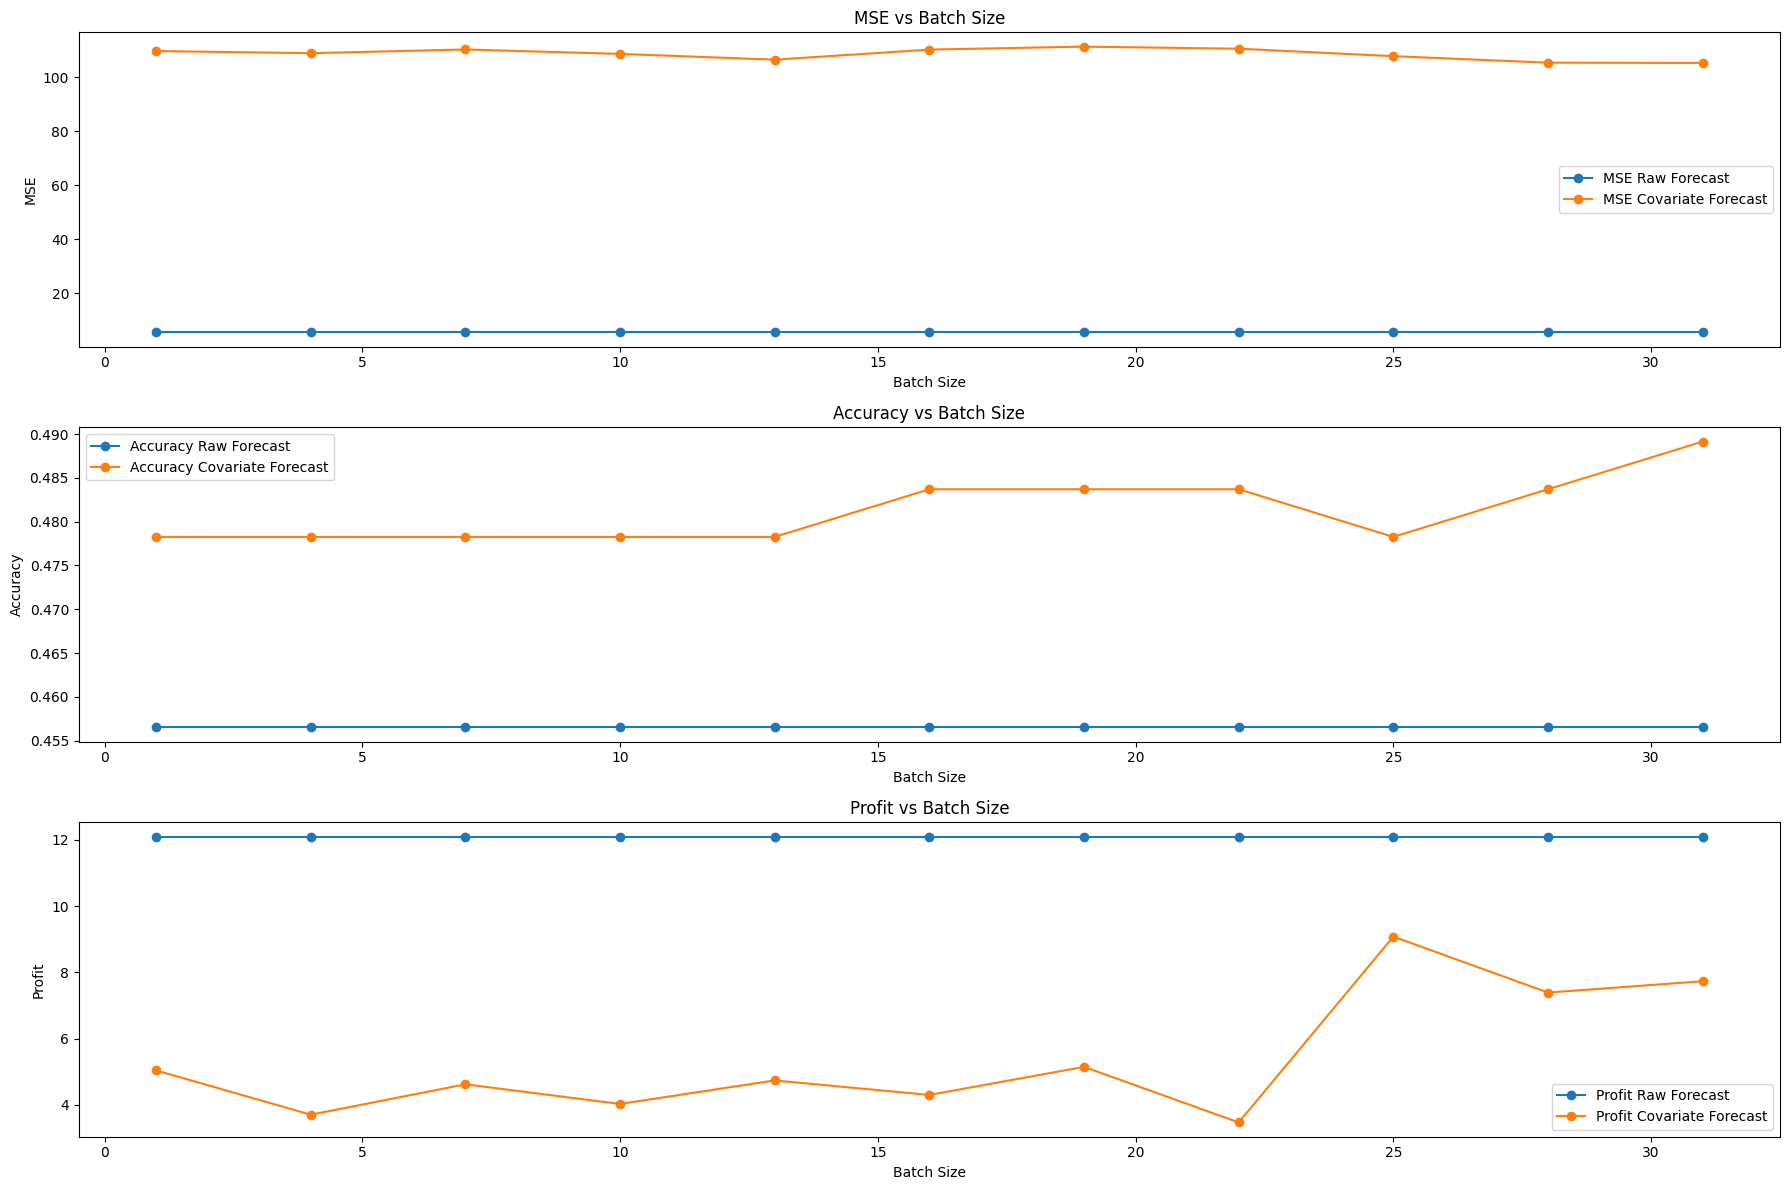

In [59]:
# Plotting the results
plt.figure(figsize=(18, 12))

# Plot MSE
plt.subplot(3, 1, 1)
plt.plot(final_results_df['batch_size'], final_results_df['mse_raw'], label='MSE Raw Forecast', marker='o')
plt.plot(final_results_df['batch_size'], final_results_df['mse_cov'], label='MSE Covariate Forecast', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('MSE')
plt.title('MSE vs Batch Size')
plt.legend()

# Plot Accuracy
plt.subplot(3, 1, 2)
plt.plot(final_results_df['batch_size'], final_results_df['accuracy_raw'], label='Accuracy Raw Forecast', marker='o')
plt.plot(final_results_df['batch_size'], final_results_df['accuracy_cov'], label='Accuracy Covariate Forecast', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.legend()

# Plot Profit
plt.subplot(3, 1, 3)
plt.plot(final_results_df['batch_size'], final_results_df['profit_raw'], label='Profit Raw Forecast', marker='o')
plt.plot(final_results_df['batch_size'], final_results_df['profit_cov'], label='Profit Covariate Forecast', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Profit')
plt.title('Profit vs Batch Size')
plt.legend()

plt.tight_layout()
plt.show()